# Compare the original predictive model with models with fewer variables.

In this notebook, we will compare the performance of the XGB precision-focused model that we chose for app1 with similar models that are optimized using the same methodology but have fewer input variables. The goal is to use a simpler model that generates a more satisfying and efficient user experience. App2 determines the probability of a customer leaving based on a manually loaded form and generates instructions for the agent from there.

## Libraries import

In [2]:
# adjusText installation so that the texts of the models do not overlap in the scatterplot.
!pip install adjustText

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Libraries import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, ConfusionMatrixDisplay, PrecisionRecallDisplay
from adjustText import adjust_text
import time
from google.colab import drive

In [4]:
# Dataset imported from github 
# Obtained from de Kaggle https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset
url='https://raw.githubusercontent.com/neoncoip/practice/main/Telco_customer_churn.csv'
telco = pd.read_csv(url, sep=';')
seed = 15

In [5]:
# Define function to calculate relevant metrics for each model we build
def met_gra(y_test, y_pred_test, y_train, y_pred_train, want_return=True): 
  """Calculates recall and precision over test data and prints results. 
     Calculates f1 over test and training data and shows ratio (to check fitting).
     Shows confusion matrix and plots recall vs precision.

  Args:
    y_test (pandas.Series): test data labels.
    y_pred_test (pandas.Series): prediction on test data.
    y_train (pandas.Series): training data labels.
    y_pred_train (pandas.Series): prediction on training data.
    want_return (bool, optional): allows to return nothing.

  Returns:
    float: recall rounded to 2 decimal places.
    float: precision rounded to 2 decimal places.
    float: ratio between f1 on test data and f1 on training data rounded to 2 decimal places.
  """
  
  # Set decimals for rounding
  deci = 2
  
  # Get f1 for train ans test data (check overfiting)
  train_f1 = f1_score(y_train, y_pred_train)
  test_f1 = f1_score(y_test, y_pred_test)
  
  # Calculate and print key metrics
  rec_score = recall_score(y_test, y_pred_test)
  pre_score = precision_score(y_test, y_pred_test)
  print('test/train F1= '+round(test_f1/train_f1, deci).astype(str),
        'recall = '+round(rec_score, deci).astype(str),
        'precision = '+round(pre_score, deci).astype(str), sep='\n')
  
  # Confusion matrix and precision/recall plot
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize='all', labels=[1, 0], colorbar=False, cmap='BuPu', ax=ax[0])
  PrecisionRecallDisplay.from_predictions(y_test, y_pred_test, ax=ax[1])
  plt.legend(loc='best')
  plt.show()
  
  # If not specified otherwise, return the values in the call.
  if want_return:
    return round(rec_score, 2), round(pre_score, 2), round(test_f1, 3)

In [6]:
#Creamos función para entrenar y testear modelos
def modelar(X, y):
  """Split data into training and test datasets.
     Run a RandomSearchCV on an XGB classifier.
     Store relevant performance metrics and models using "met_gra" function.
  
  Args:
     X (pandas.DataFrame): Unlabeled dataset 
     y (pandas.Series): Labels

  Return:
    (pandas.Dataframe): name, recall, precision, best estimator and predictions

  Notes:
    Also save the trained models in txt format to the local directory.t
  """
  
  # Split data into training and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, stratify=y)

  # Define metrics that are going to be tested on Random Search CV
  metrics = ['precision', 'recall', 'average_precision'] #'balanced_accuracy' y 'f1' converge to recall

  # Define internal XGB evaluation metrics (Tried 'auc' and 'logloss' but they ended up converging to precision and recall values)
  eval_metrics = ['aucpr']

  # Define hyperparameters to be tested
  eta = [0.03, 0.1, 0.3]
  max_depth = [2, 3, 6, 10]
  subsample = [0.5, 0.8, 1]
  spw = [1, 3]

  # Define the percentage of tests in relation to the possible combinations
  random_ratio = 0.2

  # Define the number of RSCV iterations
  n_iter = len(eta) * len(max_depth) * len(subsample) * len(spw) * random_ratio 

  # Create and prepare a dataframe to save and compare metrics of each tested model
  models = pd.DataFrame()
  models['metrics'] = []
  models['recall'] = []
  models['precision'] = []
  models['bestimator'] = []
  models['test_predictions'] = []

  # Define the start time to monitor the execution time
  start = time.time()
 
  # Iterate through the model evaluation metrics (currently using only 'aucpr') and the scoring metrics of the Random Search.
  for em in eval_metrics:
    for m in metrics:
      xgb_clf = xgb.XGBClassifier(objective='binary:logistic', seed=seed)
      param_distributions = {'eta': eta,  
                            'max_depth': max_depth,                              
                            'subsample': subsample,
                            'scale_pos_weight': spw,                        
                            'eval_metric': [em]}
      
      # Instantiate a Random Search CV with our estimator, parameter dictionary, and the current scoring metric
      xgb_rscv = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param_distributions, scoring=m, cv=5, n_jobs=-1, random_state=seed, n_iter=n_iter)
      
      # Train model
      xgb_rscv.fit(X_train, y_train)
      
      # Get best predictions on the test set
      y_pred_test = xgb_rscv.best_estimator_.predict(X_test)
      y_pred_train = xgb_rscv.best_estimator_.predict(X_train)
      
      # Display the relevant data of the best model for each scoring metric
      print('Evaluation:', em, ' - Scoring metric:', m)
      print(xgb_rscv.best_params_)
      rs, ps, _= met_gra(y_test, y_pred_test, y_train, y_pred_train)
      
      # Save the data of each iteration in the same dataframe
      models = models.append({'metrics': em+'-'+m, 'recall': rs, 'precision': ps, 'bestimator': xgb_rscv.best_estimator_, 'test_predictions': y_pred_test}, ignore_index=True)
      print('\n')

      # Save each model in a file (to use in implementation 1)
      xgb_rscv.best_estimator_.save_model(f'{em}-{m}-{X.shape[1]}var.txt')  

      # Plot attributes list and relative importance
      fig, ax = plt.subplots(figsize=(10, np.sqrt(X.shape[1]-2)))
      xgb.plot_importance(xgb_rscv.best_estimator_, ax=ax, height=0.5, color='gold')
      plt.grid(False)
      plt.show()

  # Display execution time
  end = time.time()
  elapsed = end - start
  print(f'Elapsed: {round(elapsed/60)} minutes\n')

  # Return models and their metrics
  return models

## XGBoost classifier hyperparameter tuning - Original model variables

Evaluation: aucpr  - Scoring metric: precision
{'subsample': 0.8, 'scale_pos_weight': 1, 'max_depth': 2, 'eval_metric': 'aucpr', 'eta': 0.1}
test/train F1= 0.94
recall = 0.52
precision = 0.68


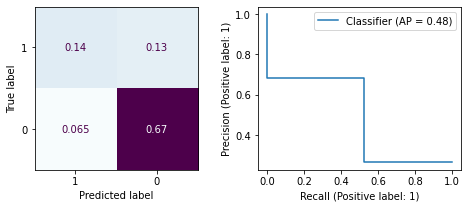

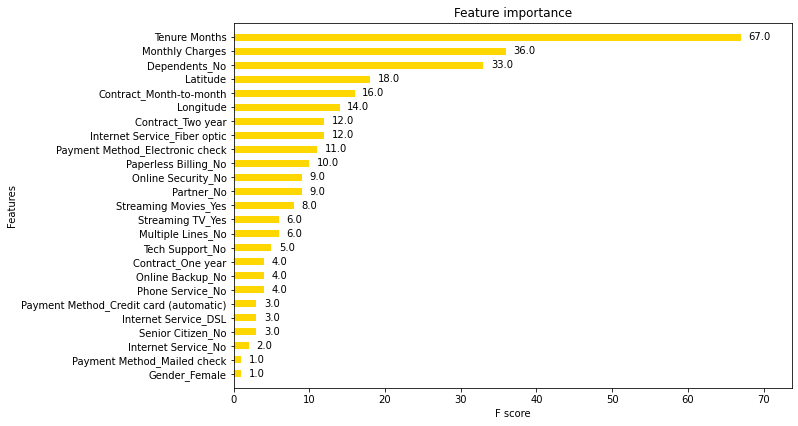

Evaluation: aucpr  - Scoring metric: recall
{'subsample': 0.5, 'scale_pos_weight': 3, 'max_depth': 3, 'eval_metric': 'aucpr', 'eta': 0.03}
test/train F1= 0.93
recall = 0.79
precision = 0.5


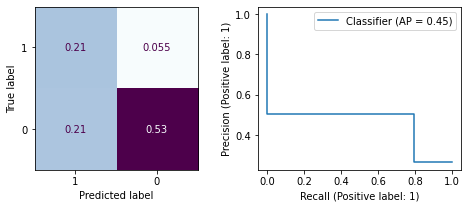

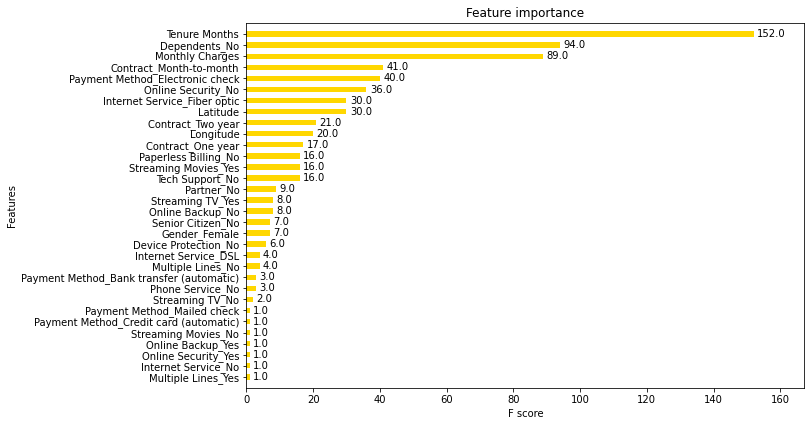

Evaluation: aucpr  - Scoring metric: average_precision
{'subsample': 0.8, 'scale_pos_weight': 1, 'max_depth': 2, 'eval_metric': 'aucpr', 'eta': 0.1}
test/train F1= 0.94
recall = 0.52
precision = 0.68


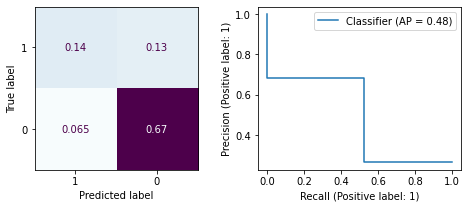

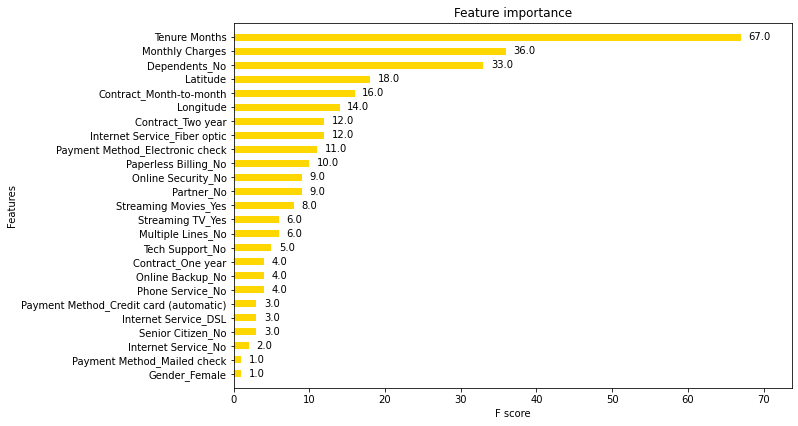

Elapsed: 4 minutes



In [7]:
# Assign label series
y = telco['Churn Value'].copy()

# Create new dataframe from original original dataset but without the previous referenced columns
X_pre = telco.drop(['CustomerID', 'Count', 'Country', 'City', 'Zip Code', 'State', 'Lat Long', 'Churn Label', 'Churn Value', 'Churn Score', 'Churn Reason', 'CLTV', 'Total Charges'], axis=1)

# Define list with columns to convert to number
cols = ['Longitude', 'Latitude', 'Monthly Charges']

# Replace comma with point and space with nothing and convert to number
X_pre[cols] = X_pre[cols].apply(lambda x: x.str.replace(',', '.')).apply(lambda x: x.str.replace(' ', '0')).apply(lambda x: pd.to_numeric(x))

# Convert categorical variables to new binary variables
X = pd.get_dummies(X_pre)

# Get models and metrics
models_ori = modelar(X, y)

## XGBoost classifier hyperparameter tuning - 8 variables 

Evaluation: aucpr  - Scoring metric: precision
{'subsample': 0.8, 'scale_pos_weight': 1, 'max_depth': 2, 'eval_metric': 'aucpr', 'eta': 0.1}
test/train F1= 0.93
recall = 0.5
precision = 0.66


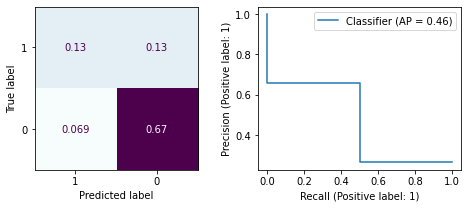

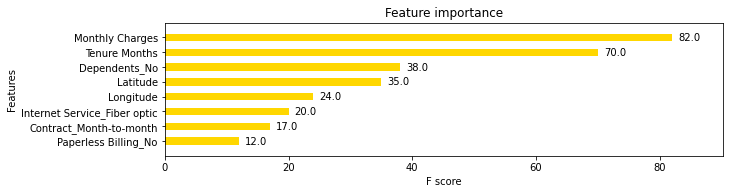

Evaluation: aucpr  - Scoring metric: recall
{'subsample': 0.5, 'scale_pos_weight': 3, 'max_depth': 2, 'eval_metric': 'aucpr', 'eta': 0.03}
test/train F1= 0.95
recall = 0.79
precision = 0.5


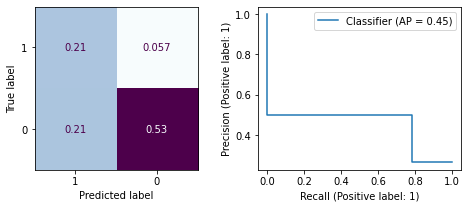

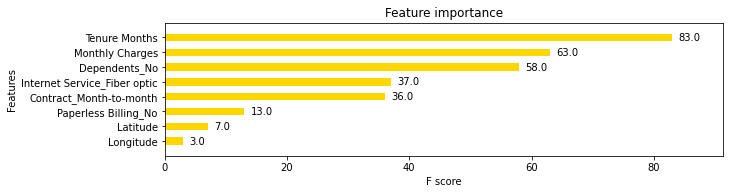

Evaluation: aucpr  - Scoring metric: average_precision
{'subsample': 0.5, 'scale_pos_weight': 3, 'max_depth': 3, 'eval_metric': 'aucpr', 'eta': 0.03}
test/train F1= 0.94
recall = 0.78
precision = 0.51


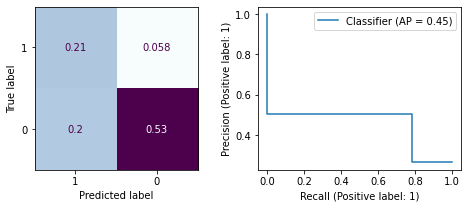

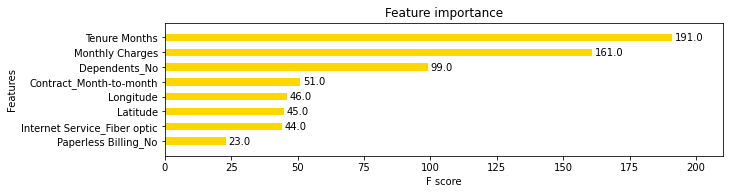

Elapsed: 1 minutes



In [8]:
# Keep first 8 variables obtained in original model (graphs above)
X_8var = X[['Tenure Months', 'Monthly Charges', 'Dependents_No', 'Latitude', 'Longitude', 'Paperless Billing_No', 'Contract_Month-to-month', 'Internet Service_Fiber optic']]

# Get models and metrics
models_8var = modelar(X_8var, y)

## XGBoost classifier hyperparameter tuning - 5 variables 

Evaluation: aucpr  - Scoring metric: precision
{'subsample': 0.8, 'scale_pos_weight': 1, 'max_depth': 2, 'eval_metric': 'aucpr', 'eta': 0.1}
test/train F1= 0.9
recall = 0.42
precision = 0.66


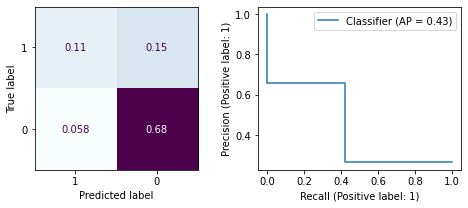

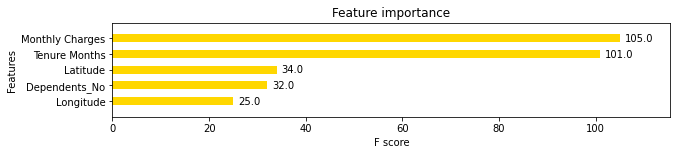

Evaluation: aucpr  - Scoring metric: recall
{'subsample': 0.5, 'scale_pos_weight': 3, 'max_depth': 2, 'eval_metric': 'aucpr', 'eta': 0.03}
test/train F1= 0.94
recall = 0.79
precision = 0.48


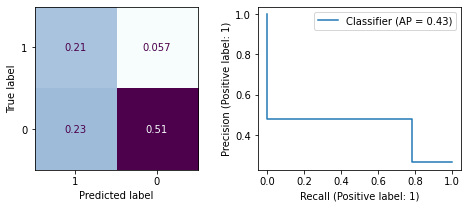

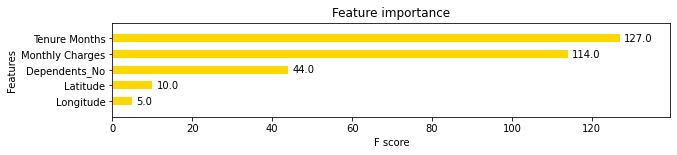

Evaluation: aucpr  - Scoring metric: average_precision
{'subsample': 0.5, 'scale_pos_weight': 3, 'max_depth': 3, 'eval_metric': 'aucpr', 'eta': 0.03}
test/train F1= 0.94
recall = 0.78
precision = 0.48


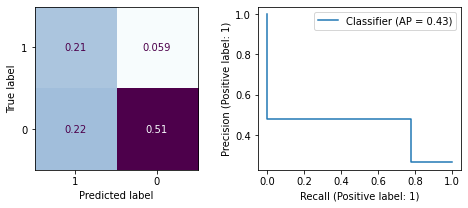

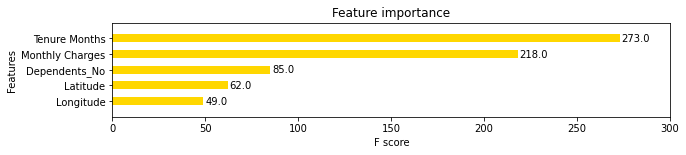

Elapsed: 1 minutes



In [9]:
# Keep first 5 variables obtained in original model (graphs above)
X_5var = X[['Tenure Months', 'Monthly Charges', 'Dependents_No', 'Latitude', 'Longitude']]

# Get models and metrics
models_5var = modelar(X_5var, y)

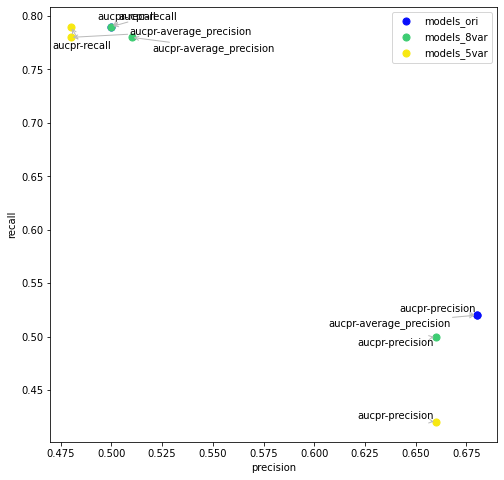

In [10]:
# Display precision and recall comparison
fig, ax = plt.subplots()
texts = []
for models, color, label in zip([models_ori, models_8var, models_5var],['#080ffc','#3dcc72','#f7e811'], ['models_ori', 'models_8var', 'models_5var']):
  models.plot(ax=ax, kind='scatter', x='precision', y='recall', figsize=(8,8), c=color, s=50, label=label)
  for i in range(models.shape[0]):
    texts.append(plt.text(models['precision'][i], models['recall'][i], models['metrics'][i]))
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='#bababa'), force_text=(0.3,0.6))
ax.legend()
plt.show()

# Preliminary Conclusions - Number of model variables

>Both the 5 and 8 variables models 'aucpr-precision' achieve a precision of 66%, 2 points below the complete/original model, but 5-variable model get much lower recall, 10 points below original model while 8-variable model is only 2 points below.<br>
>If whe look at recall models the differences are less dramatic, recall is the same but precision is 2 points below (48%) for 5-variable model while 8-variable model achieves a slightly higher at (50%) and this matches original model.<br>
>Therefore, we will go deeper into analyzing the behavior of the 8-variable models looking for the best performance in the higher precision ranges.

In [11]:
# Define function to get recall-precision pairs based on threshold, calculate averages and relative error
def rec_pre_pairs(trained_model, X, y, seed):
  """Generates recall-precision pairs based on threshold into several columns

  Args:
    trained_model (str): name of file/model trained 
    X (pandas.DataFrame): unlabeled data
    y (pandas.Series): labels
    seed (int): train_test_split random_state seed

  Return:
    (pandas.DataFrame): recall, precision y threshold
  """  
  # Set parameters to define study intervals and create a list to store threshold values
  desde=0.5
  hasta=0.95
  definición=9 # How many intervals
  thresh = []
  
  # Instantiate new model and load trained model
  model_replica = xgb.XGBClassifier()
  model_replica.load_model(trained_model)

  # Split data into training and test sets
  _, X_test, _, y_test = train_test_split(X, y, random_state=seed, stratify=y)
  
  # Generate probability values for positive churn and concatenate them to the actual predictions
  proba =  model_replica.predict_proba(X_test)[:,1]
  data_plus_proba = pd.concat([y_test.reset_index()['Churn Value'], pd.DataFrame(proba, columns = ['Proba'])], axis=1)
  
  # Generate the binary labels (columns) to calculate recall and precision.
  for i in range(definición+1):
    data_plus_proba[f'gt{i*10}'] = data_plus_proba['Proba'].apply(lambda x: 1 if x>=desde+i*(hasta-desde)/definición else 0)
    thresh.append(round(desde+i*(hasta-desde)/definición, 2)) 

  # Calculate and save recall and precision values
  rec_pre = pd.DataFrame()
  rec_pre['recall'] = []
  rec_pre['precision'] = []
  for col in data_plus_proba:
    if col not in ['Churn Value', 'Proba']:
      recall = round(recall_score(data_plus_proba['Churn Value'], data_plus_proba[col], zero_division=0), 2)
      precision = round(precision_score(data_plus_proba['Churn Value'], data_plus_proba[col], zero_division=0), 2) 
      rec_pre = rec_pre.append({'recall': recall, 'precision': precision}, ignore_index=True)
  rec_pre['thresh'] = thresh
  
  return rec_pre

In [33]:
# Define function to calculate averages and relative error delivered by rec_pre_pairs function
def rec_pre_avg_and_error(modelo, X, y):
  """Call the rec_pre_pairs function, calculate mean, standard deviation and relative error for precision and recall for each threshold.

  Args:
    modelo (str): name of file/model trained 
    X (pandas.DataFrame): unlabeled data
    y (pandas.Series): labels

  Return:
    (pandas.DataFrame): recall and average precision, standard deviation of recall and precision, relative error of recall and precision, threshold
  """

  # Instantiate dataframes where we are going to store and average values
  recall_df = pd.DataFrame()
  precision_df = pd.DataFrame()
  recall_df_std = pd.DataFrame()
  precision_df_std = pd.DataFrame()
  avg_and_error = pd.DataFrame()

  # Generate n iterations of the function with different seed and store recall and precision series.
  repeticiones = 50
  for i in range(repeticiones):
    pairs = rec_pre_pairs(modelo, X, y, i)
    recall_df.insert(i, i, pairs['recall'])
    precision_df.insert(i, i, pairs['precision'])

  # Get recall and precision averages
  avg_and_error['re_avg'] = recall_df.mean(axis=1).round(2)
  avg_and_error['pre_avg'] = precision_df.mean(axis=1).round(2)

  # Get standard deviations for both data groups and add to the dataframe where we already had the averages.
  import statistics as st

  re_std = []
  for row in recall_df.iterrows():
    re_std.append(st.stdev(row[1]))
  avg_and_error['re_std'] = pd.Series(re_std)

  pre_std = []
  for row in precision_df.iterrows():
    pre_std.append(st.stdev(row[1]))
  avg_and_error['pre_std'] = pd.Series(pre_std)

  # Calculate relative error using sigma=1.96 to ensure 95% accuracy in the error estimation
  sigma = 1.96
  avg_and_error['re_rel_error'] = sigma * avg_and_error['re_std']/avg_and_error['re_avg']
  avg_and_error['pre_rel_error'] = sigma * avg_and_error['pre_std']/avg_and_error['pre_avg']
  avg_and_error['thresh'] = pairs['thresh']
  avg_and_error.replace(0, np.nan, inplace=True)
  
  return avg_and_error

In [34]:
import glob
models = glob.glob("*8var.txt")

models_data = []
for model in models:
  response = rec_pre_avg_and_error(model, X_8var, y)
  models_data.append(response)
  model_name = f'{model}'[:-4]
  response.to_csv(f'{model_name}.csv')
  print(model_name, response, sep='\n')

aucpr-recall-8var
   re_avg  pre_avg    re_std   pre_std  re_rel_error  pre_rel_error  thresh
0    0.82     0.52  0.014165  0.010583      0.033858       0.039890    0.50
1    0.80     0.54  0.015301  0.011147      0.037488       0.040458    0.55
2    0.76     0.56  0.016164  0.012480      0.041685       0.043681    0.60
3    0.71     0.59  0.019086  0.013864      0.052689       0.046056    0.65
4    0.53     0.65  0.024295  0.020127      0.089845       0.060691    0.70
5    0.40     0.71  0.020548  0.023190      0.100683       0.064019    0.75
6    0.25     0.75  0.019430  0.030968      0.152328       0.080930    0.80
7    0.04     0.92  0.008254  0.054379      0.404428       0.115851    0.85
8     NaN      NaN       NaN       NaN           NaN            NaN    0.90
9     NaN      NaN       NaN       NaN           NaN            NaN    0.95
aucpr-precision-8var
   re_avg  pre_avg    re_std   pre_std  re_rel_error  pre_rel_error  thresh
0    0.54     0.67  0.017815  0.017981      0.064

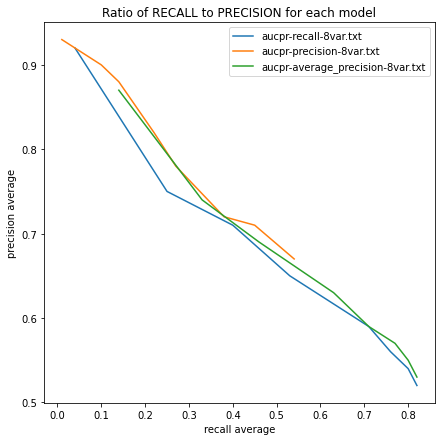

In [35]:
fig, ax = plt.subplots(figsize=(7,7))
for data, name in zip(models_data, models):
  data.plot(ax=ax, label=name, kind='line', y='pre_avg', x='re_avg')
ax.set_xlabel('recall average')
ax.set_ylabel('precision average')
ax.set_title('Ratio of RECALL to PRECISION for each model')
plt.show()

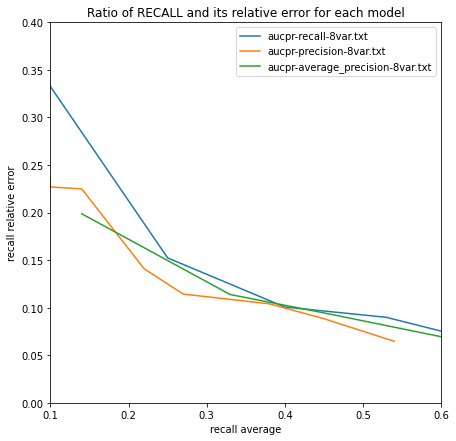

In [36]:
fig, ax = plt.subplots(figsize=(7,7))
for data, name in zip(models_data, models):
  data.plot(ax=ax, label=name, kind='line', x='re_avg', y='re_rel_error')
  plt.xlim(0.1, 0.6)
  plt.ylim(0, 0.4)
ax.set_xlabel('recall average')
ax.set_ylabel('recall relative error')
ax.set_title('Ratio of RECALL and its relative error for each model')
plt.show()

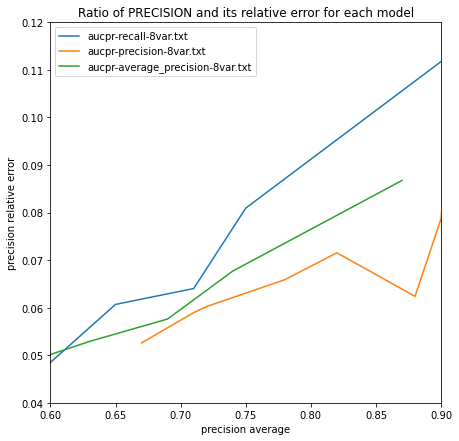

In [39]:
fig, ax = plt.subplots(figsize=(7,7))
for data, name in zip(models_data, models):
  data.plot(ax=ax, label=name, kind='line', x='pre_avg', y='pre_rel_error')
  plt.xlim(0.6, 0.9)
  plt.ylim(0.04, 0.12)
ax.set_xlabel('precision average')
ax.set_ylabel('precision relative error')
ax.set_title('Ratio of PRECISION and its relative error for each model')
plt.show()  

# Final Conclusions - Model selection

>We choose the 8-variable model 'aucpr-precision' to use in App2. It is the best option to work with the upper range of precision because:<br>
* At the same precision value, it provides better recall values, approximately 40% higher for the precision range between 75% and 90%.
* It has the lowest relative error values for precision. Around 2% lower in the range between 75% and 90%, which represents an approximately 25% lower relative error.